# Der Funkkanal
Dieses Notebook dient als Theorie-Verständnisübung für Überlegungen zum allgemeinen Funkkanal. Die Annahmen und Formeln beruhen, soweit nicht weiter kenntlich gemacht, auf [Kammeyer, 2004](https://link.springer.com/book/10.1007/978-3-322-94062-9). 
________
Als aller erstes soll hierzu der **AWGN Kanal für ein SISO System** untersucht werden. Am einfachsten ist hier zuerst die Untersuchung hinsichtlich der Bitfehlerwarscheinlichkeit, da diese mit vielen Beispielen (u.a. Matlab MKS) hinreichend dokumentiert ist. Kammeyer beschreibt die Formel

\begin{equation}
\tag{15.2.2}
P_b = K \cdot erfc \left ( \sqrt{\frac{E_b}{N_0} \gamma^2} \right )
\end{equation}

wobei $K$ und $\gamma^2$ jeweils durch die jeweiligen Modulationsformate gegeben sind (siehe Tabelle Seite 563). Wichtiger ist hierbei festzustellen, dass wir ebenfalls von $\frac{E_b}{N_0}$ und $\frac{E_S}{N_0}$ sprechen - also Energie _pro bit_ bzw. _pro Symbol_ durch _Rauschleistung pro 1 Hz_. Dieses ist wichtig, da wir das SNR standardmäßig pro bit addressieren. Eine Umrechnung von (linearem) SNR zu $\frac{E_S}{N_0}$ kann erfolgen, indem man das SNR auf $E_S$ skaliert, indem man das gewünschte SNR mit der Anzahl der bits pro Symbol multipliziert. 

\begin{equation}
\tag{--}
\frac{E_S}{N_0} = SNR_{lin} \cdot log2(M)
\end{equation}

wobei $M$ Im folgenden soll im Bereich von 0-40dB SNR die Bitfehlerwarscheinlichleit für eine QPSK über den AWGN-Kanal untersucht werden. Für QPSK gilt $K = 1/2$ und $\gamma^2 = 1$.


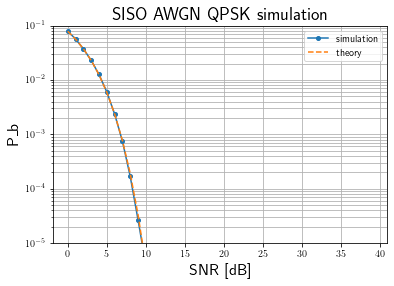

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import comm as comm
import copy
from scipy import special

plt.rcParams['text.usetex'] = True

#setting some parameters
n_symbols = 5e5
format_transmission = "PSK"
order = 4
Nr = 1

#generating some placeholders
snr_list = np.arange(0,40)
EsNo = 10**(snr_list/10)*np.log2(order) #skalierung von SNR auf SNR pro Symbol
EbNo = EsNo/np.log2(order) #skalierung von SNR pro Symbol auf SNR pro Bit
ber_res = np.ones(snr_list.shape)

for k in range(len(snr_list)):
    
    #generating signal object
    sig_tx = comm.signal.Signal(n_dims=Nr)
    sig_tx.generate_bits(n_bits=int(n_symbols*np.log2(order)),seed=None)
    sig_tx.generate_constellation(format=format_transmission, order=order)
    sig_tx.mapper()
    sig_tx.pulseshaper(upsampling=1, pulseshape="None") #we need this here, because of copying stuff in comm
    
    #### Channel ###################
    sig_ch = copy.deepcopy(sig_tx)
    sig_ch.samples[0] = comm.channel.set_snr(sig_ch.samples[0], snr_dB=10*np.log10(EsNo[k]))

    sig_rx = copy.deepcopy(sig_ch)

    sig_rx.decision()
    sig_rx.demapper()
    
    ber_res[k] = comm.rx.count_errors(sig_rx.bits[0], sig_rx.samples[0])["ber"]

awgn_theory_qpsk = 1/2 * special.erfc(np.sqrt(EbNo*1**2))   

plt.title("SISO AWGN QPSK simulation", fontsize=18)
plt.semilogy(snr_list, ber_res, marker="o", markersize=4, label="simulation")
plt.semilogy(snr_list, awgn_theory_qpsk, ls="--", label="theory")
plt.xlabel("SNR [dB]", fontsize=16)
plt.ylabel(r"P_b", fontsize=16)
plt.legend()
plt.ylim(1e-5,1e-1)
plt.grid(visible=True, which="both")
plt.show()

_______
Da die Funkkanal-Theorie insbesondere unter Betrachtung des Mobilfunkkanals Anwendung findet, werden insbesondere Beispiele aus diesem Bereich innerhalb der Literatur behandelt. Ein ebenfalls sehr prominentes Beispiel stellt dabei ein **SISO-System mit Rayleigh-Fading** dar. Dieses Kanalmodell beschreibt den Umstand, dass die Übertragung nur NLOS Signalelemente und keine LOS Signalelemente enthält. Dieses soll im folgenden untersucht werden. 
Das Empfangssignal eines Rayleigh-Funkkanals kann definiert werden als 

\begin{equation}
\tag{15.2.1}
r(t) = A \cdot e^{j\psi_0} s(t) + n(t)
\end{equation}

wobei $A$ eine Zufallsvariable mit Rayleigh-Verteilung darstellt, und sich somit der komplexe Kanalfaktor $A \cdot  e^{j\psi_0}$ ergibt. Dieses gilt, solange angenommen werden kann, dass der Phasenfehler $\psi_0$ im kohärenten System ideal kompensiert wird, und sich somit zu 0 ergbit. Kammeyer errechnet aus der Formel 15.2.2 mithilfe der Rayleigh-Verteilung eine für einen Rayleigh-Kanal angenomme Formel der [ergodischen](https://de.wikipedia.org/wiki/Ergodizität#Allgemeines) Bitfehlerwarscheinlichkeit 

\begin{equation}
\tag{15.2.10}
\bar{P_b}^{Ray} = K \cdot \left ( 1 - \sqrt{\frac{\gamma^2 \bar{E_b}/N_0}{ 1 - \gamma^2 \bar{E_b}/N_0}} \right )
\end{equation}

die sich im Falle von QPSK zu 

\begin{equation}
\tag{15.2.11a}
\bar{P_b}^{Ray, QPSK} = 1/2 \cdot \left ( 1 - \sqrt{\frac{\bar{E_b}/N_0}{ 1 - \bar{E_b}/N_0}} \right )
\end{equation}

ergibt. Die dargestelle ergodische Bitfehlerwarscheinlichkeit gilt für den Fall idealer Kanalkenntnis - und somit idealer Kanalkompensation. Für die Simulation bedeutet dieses, dass die erzeugten Kanalkoeffizienten bekannt sind, und zur idealen Kompensation benutzt werden können.

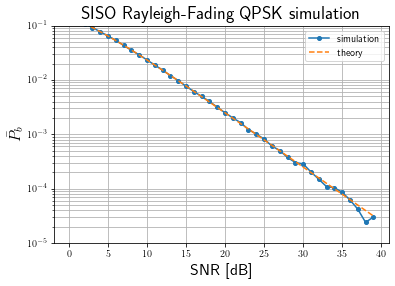

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import comm as comm
import copy
from scipy import special

plt.rcParams['text.usetex'] = True

#setting some parameters
n_symbols = 5e5
format_transmission = "PSK"
order = 4
Nr = 1

#generating some placeholders
snr_list = np.arange(0,40)
EsNo = 10**(snr_list/10)*np.log2(order) #skalierung von SNR auf SNR pro Symbol
EbNo = EsNo/np.log2(order) #skalierung von SNR pro Symbol auf SNR pro Bit
ber_res = np.ones(snr_list.shape)

for k in range(len(snr_list)):
    
    #generating signal object
    sig_tx = comm.signal.Signal(n_dims=Nr)
    sig_tx.generate_bits(n_bits=int(n_symbols*np.log2(order)),seed=None)
    sig_tx.generate_constellation(format=format_transmission, order=order)
    sig_tx.mapper()
    sig_tx.pulseshaper(upsampling=1, pulseshape="None") #we need this here, because of copying stuff in comm
    
    #### Channel ###################
    sig_ch = copy.deepcopy(sig_tx)
    
    #generate rayleigh channel coefficients
    psi_0 = 0 #ideal compensated phase 
    rayleigh_channel_coefficients = np.random.default_rng().rayleigh(size=len(sig_ch.samples[0]))*np.exp(1j*psi_0)
    #normalise raylight channel coefficients to 1
    #rayleigh_channel_coefficients = rayleigh_channel_coefficients*np.sqrt(1/np.mean(np.abs(rayleigh_channel_coefficients)**2))
    
    #apply rayleigh fading channel to samples
    sig_ch.samples[0] = sig_ch.samples[0] * rayleigh_channel_coefficients
    
    #add noise to signal
    sig_ch.samples[0] = comm.channel.set_snr(sig_ch.samples[0], snr_dB=10*np.log10(EsNo[k]))
    
    #compensate the rayleigh fading channel ideal
    sig_ch.samples[0] = sig_ch.samples[0] * np.conj(rayleigh_channel_coefficients)
    
    sig_rx = copy.deepcopy(sig_ch)

    sig_rx.decision()
    sig_rx.demapper()
    
    ber_res[k] = comm.rx.count_errors(sig_rx.bits[0], sig_rx.samples[0])["ber"]

ray_theory_qpsk = 1/2 * (1-np.sqrt((EbNo)/(1+EbNo))) 

plt.title("SISO Rayleigh-Fading QPSK simulation", fontsize=18)
plt.semilogy(snr_list, ber_res, marker="o", markersize=4, label="simulation")
plt.semilogy(snr_list, ray_theory_qpsk, ls="--", label="theory")
plt.xlabel("SNR [dB]", fontsize=16)
plt.ylabel(r"$$\bar{P_b}$$", fontsize=16)
plt.legend()
plt.ylim(1e-5,1e-1)
plt.grid(visible=True, which="both")
plt.show()

_______
Nachdem die SISO-Kanäle grundsätzlich untersucht wurden, sollen nun tiefere Untersuchungen mit räumlicher Diversität zum Funkkanal erfolgen. Hierfür wird ein **SIMO-System mit Rayleigh-Fading** genauer untersucht. Die Unterschiede zum bereits untersuchten SISO System liegen darin, dass nun mehere Funkkanäle quasi parrallel betrieben werden. Die Empfangssignale, in Abhängigkeit der Empfangsantenne $l$, wobei $l \in {0,...,L-1}$ (mit L als Gesamtzahl der Diversitäts-Antennen) können definiert werden als

\begin{equation}
\tag{15.3.1}
r_l(iT) = h_l \cdot d(i) + n_l(iT)
\end{equation}

wobei $h_l$ hierbei (nur) die komplexen Kanal-Bewertungsfaktoren darstellt. Kammeyer beschreibt hierbei auch die Einbeziehung von Sende- und Empfangsfilter, welches aber hier vernachlässig werden soll. Die Darstellungen $n_l(iT)$ sind Musterfunktionen für unabhägige Rauschprozesse. Die Auslegung eines Mehrantennen-Systems erzeugt die Notwendigkeit einer Kombinationsmethodik, wobei in diesem Fall das **MRC-Combining** untersucht werden soll. Das MRC-Combining hat zum Ziel, eine Linearkombiation der Empfangssignale zu bilden, welche ein maximales SNR ergibt. Die zugehörigen Kombinationskoeffizienten $c_l$ können nach einiger Umstellungen (-> Schwarschen Ungleichung) mit 

\begin{equation}
\tag{15.3.4}
c_l = h_l^*
\end{equation}

für ein maximales SNR gewählt werden. Auch hierbei wird also eine ideale Kompensierung des Kanals, ähnlich der SISO-Variante, angestrebt. Die theoretische Herleitung für die ergodische Bitfehlerwarscheinlichkeit findet sich auf den Seiten 572ff. und schließt mit der Formel

\begin{equation}
\tag{15.3.10}
\bar{P_b}^{L-Ray} = 2K \left ( \frac{1-\alpha}{2} \right )^L \cdot \sum_{l=0}^{L-1} \binom{L-1+l}{l} \left( \frac{1+\alpha}{2} \right )^l
\text{ mit } 
\alpha = \sqrt{\frac{\frac{1}{L}\gamma^2\bar{E_b}/N_0}{1+\frac{1}{L}\gamma^2\bar{E_b}/N_0}}
\end{equation}

welche angibt, wie sich die Bitfehlerwarscheinlichkeit unter Berücksichtigung eines SIMO-Systems bei idealem MRC-combining verhält. Wichtig ist hierbei zu beachten, dass sowohl diese Formel, als auch die Darstellung im Beispiel über $\bar{E_b}{N_0}$ berechnet wird. Hierbei bezeichnet $\bar{E_b}$ die mittlere am Empfänger zur Verfügung stehende Gesamtenergie. Aus dem Wissen der vorherigen Betrachtung mit dem Zusammenhang zum SNR lässt sich simulativ erkennen, dass somit das SNR nach Kombination der Einzelsignale $\bar{E_b}{N_0}$ entspricht. Es ist deshalb in der Simulation zu berücksichtigen, dass pro Einzelkanal nur ein SNR von $SNR_{Pfad} = \frac{SNR_{gesamt}}{L} = \frac{\bar{E_b}{N_0}}{L}$ zu erzeugen ist. Formal lässt sich dieses mithilfe der Gleichung nach [Creasey](https://books.google.de/books/about/Advanced_Signal_Processing.html?id=iszN4Ohe1b0C&redir_esc=y) erklären

\begin{equation}
\tag{20, Seite 44, Creasey}
\gamma_{R} = \sum_{l=1}^L \gamma_{k}
\end{equation}

wobei $\gamma_{R}$ das resultiernde SNR und $\gamma_{k}$ das SNR des jeweiligen Pfades beschreibt. Die Formel sagt hierbei aus, dass ein ideal kombiniertes MRC Signal als resultierendes und kombiniertes SNR immer die Summe der Pfad-SNRs ergeben muss. Einen Diversitätsgewinn im Falle einer idealen MRC-Kombination unter der Annahme von annährend gleichen Pfad-SNRs lässt sich somit einfach durch

\begin{equation}
\tag{23, Seite 44, Creasey}
\ \bar{\gamma}_{R} = L
\end{equation}

beschreiben. [Nuszkowski](https://books.google.de/books/about/Digitale_Signalübertragung_im_Mobilfunk.html?id=S03poAEACAAJ&hl=en&output=html_text&redir_esc=y) nennt diese Darstellung des Verhätnisses von SNR und MRC den sog. normierten Mittelwert (kombiniertes SNR gegenüber SNR der Einzelkanäle).

<span style="color:green">TODO: Graphen von dieser Simulation (+Kammeyer) und Rice-Kanal mit K=0 in MKS sind nicht gleich. Checken!</span>

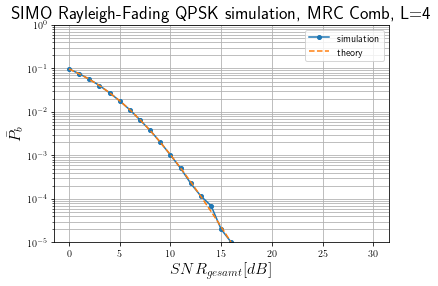

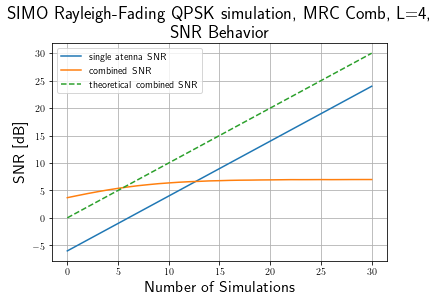

In [103]:
import numpy as np
import matplotlib.pyplot as plt
import comm as comm
import copy
from scipy import special

plt.rcParams['text.usetex'] = True

#setting some parameters
n_symbols = 5e5
format_transmission = "PSK"
order = 4
L = 4

#generating some placeholders
snr_list = np.arange(0,31)
EsNo = 10**(snr_list/10)*np.log2(order) #skalierung von SNR auf SNR pro Symbol
EbNo = EsNo/np.log2(order) #skalierung von SNR pro Symbol auf SNR pro Bit
ber_res = np.ones(snr_list.shape)
snr_comb = np.zeros(snr_list.shape)

for k in range(len(snr_list)):
    
    #generating signal object
    sig_tx = comm.signal.Signal(n_dims=L)
    sig_tx.generate_bits(n_bits=int(n_symbols*np.log2(order)),seed=None)
    sig_tx.generate_constellation(format=format_transmission, order=order)
    sig_tx.mapper()
    sig_tx.pulseshaper(upsampling=1, pulseshape="None") #we need this here, because of copying stuff in comm
    
    sig_tx.samples[0] =  sig_tx.samples[0] * (1 / np.mean(np.abs(sig_tx.samples[0])))  
    
    #### Channel ###################
    sig_ch = copy.deepcopy(sig_tx)
    
    #generate multiple paths
    for l in range(L):
        sig_ch.samples[l] = sig_ch.samples[0]
    
    #generate rayleigh channel coefficients
    psi_0 = 0 #ideal compensated phase 
    rayleigh_channel_coefficients = np.zeros((len(sig_ch.samples),len(sig_ch.samples[0])),dtype=complex)
    for l in range(L):
        rayleigh_channel_coefficients[l,:] = np.random.default_rng().rayleigh(size=len(sig_ch.samples[0]))*np.exp(1j*psi_0)
        rayleigh_channel_coefficients[l,:] = rayleigh_channel_coefficients[l,:]*np.sqrt((1/L)/np.mean(np.abs(rayleigh_channel_coefficients[l,:])**2))


    #apply rayleigh fading channel to samples
    for l in range(L):
        sig_ch.samples[l] = sig_ch.samples[l] * rayleigh_channel_coefficients[l,:]
    
    # adding noise
    for l in range(L):
        sig_ch.samples[l] = comm.channel.set_snr(sig_ch.samples[l], snr_dB=10*np.log10(EsNo[k]/L))
    
    sig_rx = copy.deepcopy(sig_ch)
    sig_rx.samples[0] = np.zeros(len(sig_ch.samples[0]), dtype=complex)
    
    #compensate the rayleigh fading channel ideal
    for l in range(L):
        sig_rx.samples[0] += sig_ch.samples[l] * np.conj(rayleigh_channel_coefficients[l,:])
        
    sig_rx.samples[0] =  sig_rx.samples[0] * (1 / np.mean(np.abs(sig_rx.samples[0])**2))    
    snr_comb[k] = 10*np.log10(np.var(sig_tx.samples[0])/np.var(sig_rx.samples[0]-sig_tx.samples[0]))
    
    sig_rx.decision()
    sig_rx.demapper()
    
    ber_res[k] = comm.rx.count_errors(sig_rx.bits[0], sig_rx.samples[0])["ber"]
    
#generating rayleigh SIMO theory
gamma2 = 1
K = 1/2
alpha = np.sqrt(((1/L)*gamma2*EbNo)/(1+(1/L)*gamma2*EbNo))
sum_term = 0
for l in range(0,L):
    sum_term += special.binom(L-1+l,l)*((1+alpha)/2)**l
ray_theory_qpsk_div = 2*K*((1-alpha)/2)**L*sum_term

plt.title("SIMO Rayleigh-Fading QPSK simulation, MRC Comb, L={}".format(L), fontsize=18)
plt.semilogy(snr_list, ber_res, marker="o", markersize=4, label="simulation")
plt.semilogy(snr_list, ray_theory_qpsk_div, ls="--", label="theory")
plt.xlabel(r"$$SNR_{gesamt} [dB]$$", fontsize=16)
plt.ylabel(r"$$\bar{P_b}$$", fontsize=16)
plt.legend()
plt.ylim(1e-5,1)
plt.grid(visible=True, which="both")
plt.show()

plt.title("SIMO Rayleigh-Fading QPSK simulation, MRC Comb, L={}, \n SNR Behavior".format(L), fontsize=18)
plt.plot(10*np.log10(10**(snr_list/10)/L), label="single atenna SNR")
plt.plot(snr_comb, label="combined SNR")
plt.plot(snr_list, label="theoretical combined SNR", ls="--")
plt.ylabel("SNR [dB]", fontsize=16)
plt.xlabel("Number of Simulations", fontsize=16)
plt.legend()
plt.grid()
plt.show()

In [87]:
print(snr_comb)

[-1.51698588 -1.64587494 -1.79410854 -1.91099366 -2.0834468  -2.21185592
 -2.33085138 -2.43773133 -2.53179324 -2.6370264  -2.70048087 -2.76632258
 -2.81840678 -2.85643951 -2.88868554 -2.91513779 -2.9400116  -2.95556617
 -2.9769122  -2.9924833  -2.99985183 -3.01221133 -3.00982901 -3.01337502
 -3.02025271 -3.02628511 -3.02730798 -3.03778793 -3.0314576  -3.03429566
 -3.03216453]
